## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
len(df[df['converted']==1])/len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
num = len(df) - len(df[(df['group']=='treatment') == (df['landing_page']== 'new_page')])
print(num)

3893


f. Do any of the rows have missing values?

In [7]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop((df[(df['group']=='treatment') != (df['landing_page'] == 'new_page')]).index)

In [9]:
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.duplicated(subset=['user_id']).sum()

1

In [13]:
cond = (df2.duplicated(subset=['user_id'])==True)
cond

0         False
1         False
2         False
3         False
4         False
          ...  
294473    False
294474    False
294475    False
294476    False
294477    False
Length: 290585, dtype: bool

c. What is the row information for the repeat **user_id**? 

In [14]:
df2.loc[cond,:]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop_duplicates(subset=['user_id'])
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
len(df2[df2['converted']==1])/len(df2)

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control = df2.groupby('group')['converted'].mean()['control']
p_control

0.1203863045004612

In [18]:
p_control = len(df2[(df2['group']=='control') & (df2['converted'] == 1)]) / len(df2[df2['group']=='control'])
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
p_treatment = len(df2[(df2['group']=='treatment') & (df2['converted'] == 1)]) / len(df2[df2['group']=='treatment'])
p_treatment

0.11880806551510564

In [20]:
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [21]:
(len(df2[df2['landing_page']=='new_page']))/len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

No, the difference is too small to to be seen as sufficient evidence that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

* **Null Hypothesis $H_{0}$:** $p_{old} >= p_{new}$

* **Alternative Hypothesis $H_{1}$:** $p_{old} < p_{new}$ 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
convert_rate = len(df2[df2['converted']==1])/len(df2)

In [23]:
p_new = convert_rate
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old = convert_rate
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
n_new = len(df2[df2["landing_page"] == "new_page"])
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old = len(df2[df2["landing_page"] == "old_page"])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = random.choices([0, 1], k=n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = random.choices([0, 1], k=n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
diffs = np.mean(new_page_converted) - np.mean(old_page_converted) 
diffs

-0.0030700453645127745

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    b_samp = df2.sample(len(df2), replace = True)
    control_df = b_samp[b_samp['group'] == 'control']
    treatment_df = b_samp[b_samp['group'] == 'treatment']
    control_cr = control_df['converted'].mean()
    treatment_cr = treatment_df['converted'].mean()
    p_diffs.append(treatment_cr - control_cr)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

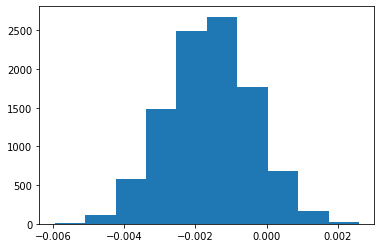

In [31]:
plt.hist(p_diffs);

This plot looks like what was obtained in the lecture.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

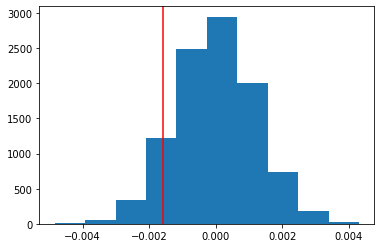

In [33]:
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');

In [34]:
(null_vals > obs_diff).mean()

0.9059

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In part **j** , we computed the **p-value** .

It is the probability that the observed difference is greater/smaller than than the distribution of differences if the null hypothesis were true. It is not significant because value is not small enough to actually reject our null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [3]:
import statsmodels.api as sm

old_page_df = df2[df2["landing_page"] == "old_page"]
new_page_df = df2[df2["landing_page"] == "new_page"]

convert_old = old_page_df["converted"].sum()
convert_new = new_page_df["converted"].sum()
n_old = len(old_page_df)
n_new = len(new_page_df)

NameError: name 'df2' is not defined

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
#sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-6.059074386432219e-05, 0.5000241722095137)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score and p-value we computed that we cannot reject the null hypothesis and that the conversion rate of the old and new pages are the same.

Yes, they do agree with the findings in parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Linear regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2["intercept"] = 1
df2["ab_page"] = (df2["group"] == "treatment").astype(int)
df2

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [1]:
lm = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
results = lm.fit()

NameError: name 'sm' is not defined

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Mon, 04 Jan 2021   Prob (F-statistic):              0.190
Time:                        23:26:07   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with **ab_page** is 0.19

It differs from the value found in **Part II** because the hypotheses are different:

For the regression model:

* **Null Hypothesis $H_{0}$:** $\beta_{0} = 0$

* **Alternative Hypothesis $H_{1}$:** $\beta_{0} \neq 0$


Whereas in **Part II**:

* **Null Hypothesis $H_{0}$:** $p_{old} >= p_{new}$

* **Alternative Hypothesis $H_{1}$:** $p_{old} < p_{new}$ 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The advantages to adding additional terms into our regression model are:

* better predictions
* ability to determine the relative influence of one or more terms to the predicted value
* ability to identify outliers or anomalies

The disadvantages to adding additional terms into our regression model are:

* outliers
* no linear relationship
* correlated errors
* non-constant variance
* multicolinearity

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1
...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0


In [41]:
df_new.groupby('country')['converted'].mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

It seems that country does not have an impact on conversion.

In [42]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,0,1,0


In [45]:
#Create interaction variable for ab_page and UK / CA
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_CA'] = df_new['ab_page'] * df_new['CA']

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
### Fit Your Linear Model And Obtain the Results
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:               3.482e-05
Time:                        23:27:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
CA             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_CA          0.0469      0.054      0.872      0.383      -0.059       0.152
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

In [ ]:
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'ab_CA', 'ab_UK']])
results = lm.fit()
results.summary()

P-values are smaller for country columns than for ab_page, but not small enough, so we confirmed our theory from above about them not being relevant for the prediction.  R squared coefficient is 0, so it means that there is no correlation.

<a id='conclusions'></a>
## Conclusions

From all the above, we can conclude based on p-value that we should not reject the null hypothesis. This is, due to the p value in both cases ( A/B test and Regression approach) shown to be the same. We can keep the old page and maintain it, and keep observing the statistical parameters. Perhaps some small changes will bring more success rather than completely changing the page.
